In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *

import xgboost as xgb

from sklearn.metrics import mean_squared_error

In [35]:
data = pd.read_csv('./Datas/dataset_apartment.csv', index_col=0)
data

,type_of_property,subtype_of_property,locality,province,région,price,number_of_facades,house_area,house_area_cat,number_of_rooms,...,terrace,terrace_area,open_fire,swimming_pool,state_of_the_building,construction_year,construction_year_cat,price_per_m²,commune,rank_commune
0,apartment,apartment,4000,Liège,Région wallonne,45000,2.0,47.0,[0-60 m²],1,...,1,2.0,0,0,good,1958.0,1940-1959,957.45,LIÈGE,240.0
1,apartment,apartment,1030,Bruxelles-Capitale,Région Bruxelles-capitale,50000,NaN,96.0,]60-120 m²],2,...,0,NaN,0,0,good,1960.0,1960-1979,520.83,SCHAERBEEK,540.0
2,apartment,service flat,2930,Anvers,Région flamande,50000,3.0,83.0,]60-120 m²],2,...,1,NaN,0,0,NaN,2016.0,2000-,602.41,BRASSCHAAT,499.0
3,apartment,apartment,8420,Flandre-Occidentale,Région flamande,49500,2.0,31.0,[0-60 m²],1,...,0,NaN,0,0,good,1966.0,1960-1979,1596.77,DE HAAN,563.0
4,apartment,apartment,7301,Hainaut,Région wallonne,50000,2.0,49.0,[0-60 m²],1,...,0,NaN,0,0,NaN,NaN,NaN,1020.41,BOUSSU,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19831,apartment,apartment,8300,Flandre-Occidentale,Région flamande,950000,2.0,157.0,]120-180 m²],2,...,0,NaN,0,0,good,NaN,NaN,6050.96,KNOKKE-HEIST,580.0
19832,apartment,penthouse,3700,Limbourg,Région flamande,945000,NaN,164.0,]120-180 m²],3,...,0,NaN,0,0,as new,NaN,NaN,5762.20,TONGEREN,293.0
19833,apartment,apartment,6940,Luxembourg,Région wallonne,950000,NaN,111.0,]60-120 m²],2,...,1,115.0,0,0,NaN,2020.0,2000-,8558.56,DURBUY,297.0
19834,apartment,ground floor,8000,Flandre-Occidentale,Région flamande,950000,NaN,182.0,]180-240 m²],2,...,0,NaN,0,0,just renovated,NaN,NaN,5219.78,BRUGGE,556.0


In [36]:
data.columns

Index(['type_of_property', 'subtype_of_property', 'locality', 'province',
       'région', 'price', 'number_of_facades', 'house_area', 'house_area_cat',
       'number_of_rooms', 'number_of_rooms_cat', 'surface_of_the_land',
       'surface_of_the_land_cat', 'fully_equipped_kitchen', 'garden',
       'garden_area', 'terrace', 'terrace_area', 'open_fire', 'swimming_pool',
       'state_of_the_building', 'construction_year', 'construction_year_cat',
       'price_per_m²', 'commune', 'rank_commune'],
      dtype='object')

In [37]:
'''Drop the unwanted columns'''
# as we split the houses and apartments we can drop the 'type_of_property column'
data.drop(['type_of_property'], axis=1, inplace=True)

# as some subtype have a very low amount of entries , we get rid of this category
data.drop(['subtype_of_property'], axis=1, inplace=True)

# we also drop others categories made for data analysis 

to_drop = ['province', 'région', 'surface_of_the_land_cat', 'commune', 'surface_of_the_land', 
           'number_of_rooms_cat', 'construction_year_cat', 'house_area_cat', 'locality',
          'price_per_m²', 'open_fire', 'swimming_pool']
data_copy = data.copy()
for i in to_drop:
    data_copy.drop([i], axis=1, inplace=True)

data = data_copy
data

,price,number_of_facades,house_area,number_of_rooms,fully_equipped_kitchen,garden,garden_area,terrace,terrace_area,state_of_the_building,construction_year,rank_commune
0,45000,2.0,47.0,1,0,0,NaN,1,2.0,good,1958.0,240.0
1,50000,NaN,96.0,2,1,0,NaN,0,NaN,good,1960.0,540.0
2,50000,3.0,83.0,2,1,0,NaN,1,NaN,NaN,2016.0,499.0
3,49500,2.0,31.0,1,0,0,NaN,0,NaN,good,1966.0,563.0
4,50000,2.0,49.0,1,1,0,NaN,0,NaN,NaN,NaN,27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
19831,950000,2.0,157.0,2,1,1,NaN,0,NaN,good,NaN,580.0
19832,945000,NaN,164.0,3,1,0,NaN,0,NaN,as new,NaN,293.0
19833,950000,NaN,111.0,2,0,0,NaN,1,115.0,NaN,2020.0,297.0
19834,950000,NaN,182.0,2,1,0,NaN,0,NaN,just renovated,NaN,556.0


In [38]:
data.isna().sum()

price                         0
number_of_facades          7765
house_area                    0
number_of_rooms               0
fully_equipped_kitchen        0
garden                        0
garden_area               18461
terrace                       0
terrace_area               9820
state_of_the_building      4912
construction_year          5988
rank_commune                  0
dtype: int64

In [39]:
'''We will labelize categorical feature "state_of_the_building" '''
# create the dict that will be use to replace values in the category
labels = data['state_of_the_building'].astype('category').cat.categories.tolist()
replace_map= {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}
print(replace_map)

{'as new': 1, 'good': 2, 'just renovated': 3, 'to be done up': 4, 'to renovate': 5, 'to restore': 6}


In [40]:
# then we use replace method with the created dict
data.replace(replace_map, inplace=True)

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 19836 entries, 0 to 19835
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   price                   19836 non-null  int64  
 1   number_of_facades       12071 non-null  float64
 2   house_area              19836 non-null  float64
 3   number_of_rooms         19836 non-null  int64  
 4   fully_equipped_kitchen  19836 non-null  int64  
 5   garden                  19836 non-null  int64  
 6   garden_area             1375 non-null   float64
 7   terrace                 19836 non-null  int64  
 8   terrace_area            10016 non-null  float64
 9   state_of_the_building   14924 non-null  float64
 10  construction_year       13848 non-null  float64
 11  rank_commune            19836 non-null  float64
dtypes: float64(7), int64(5)
memory usage: 2.0 MB


## Set up the model

In [42]:
shape = data.shape
print(f"m = {shape[0]}, n = {shape[1] - 1}")

m = 19836, n = 11


In [43]:
# move the target column to end
col_to_put_end = ['price']
data = data[[c for c in data if c not in col_to_put_end] 
        + [c for c in col_to_put_end if c in data]]
data

,number_of_facades,house_area,number_of_rooms,fully_equipped_kitchen,garden,garden_area,terrace,terrace_area,state_of_the_building,construction_year,rank_commune,price
0,2.0,47.0,1,0,0,NaN,1,2.0,2.0,1958.0,240.0,45000
1,NaN,96.0,2,1,0,NaN,0,NaN,2.0,1960.0,540.0,50000
2,3.0,83.0,2,1,0,NaN,1,NaN,NaN,2016.0,499.0,50000
3,2.0,31.0,1,0,0,NaN,0,NaN,2.0,1966.0,563.0,49500
4,2.0,49.0,1,1,0,NaN,0,NaN,NaN,NaN,27.0,50000
...,...,...,...,...,...,...,...,...,...,...,...,...
19831,2.0,157.0,2,1,1,NaN,0,NaN,2.0,NaN,580.0,950000
19832,NaN,164.0,3,1,0,NaN,0,NaN,1.0,NaN,293.0,945000
19833,NaN,111.0,2,0,0,NaN,1,115.0,NaN,2020.0,297.0,950000
19834,NaN,182.0,2,1,0,NaN,0,NaN,3.0,NaN,556.0,950000


In [44]:
data.columns

Index(['number_of_facades', 'house_area', 'number_of_rooms',
       'fully_equipped_kitchen', 'garden', 'garden_area', 'terrace',
       'terrace_area', 'state_of_the_building', 'construction_year',
       'rank_commune', 'price'],
      dtype='object')

In [45]:
import math
from __future__ import division

from sklearn.linear_model import LinearRegression
from sklearn import tree, linear_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import explained_variance_score
from sklearn.impute import SimpleImputer

#imp = SimpleImputer(missing_values=np.nan, strategy='mean')
#data = imp.fit_transform(data)
# assign X and y
y = data.iloc[:,-1] #target
X = data.iloc[:, :-1] # features

In [46]:
# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.2)

In [47]:
xgb_reg = xgb.XGBRegressor(n_estimators=250, learning_rate=0.07, gamma=0, subsample=0.75,
                           colsample_bytree=0.9, max_depth=7)

In [48]:
xgb_reg.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.9, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.07, max_delta_step=0, max_depth=7,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=250, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.75,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [49]:
predictions = xgb_reg.predict(X_test)
print(explained_variance_score(predictions,y_test))

0.7137406225048


In [50]:
xgb_reg.score(X_test,y_test)

0.7778790287938744

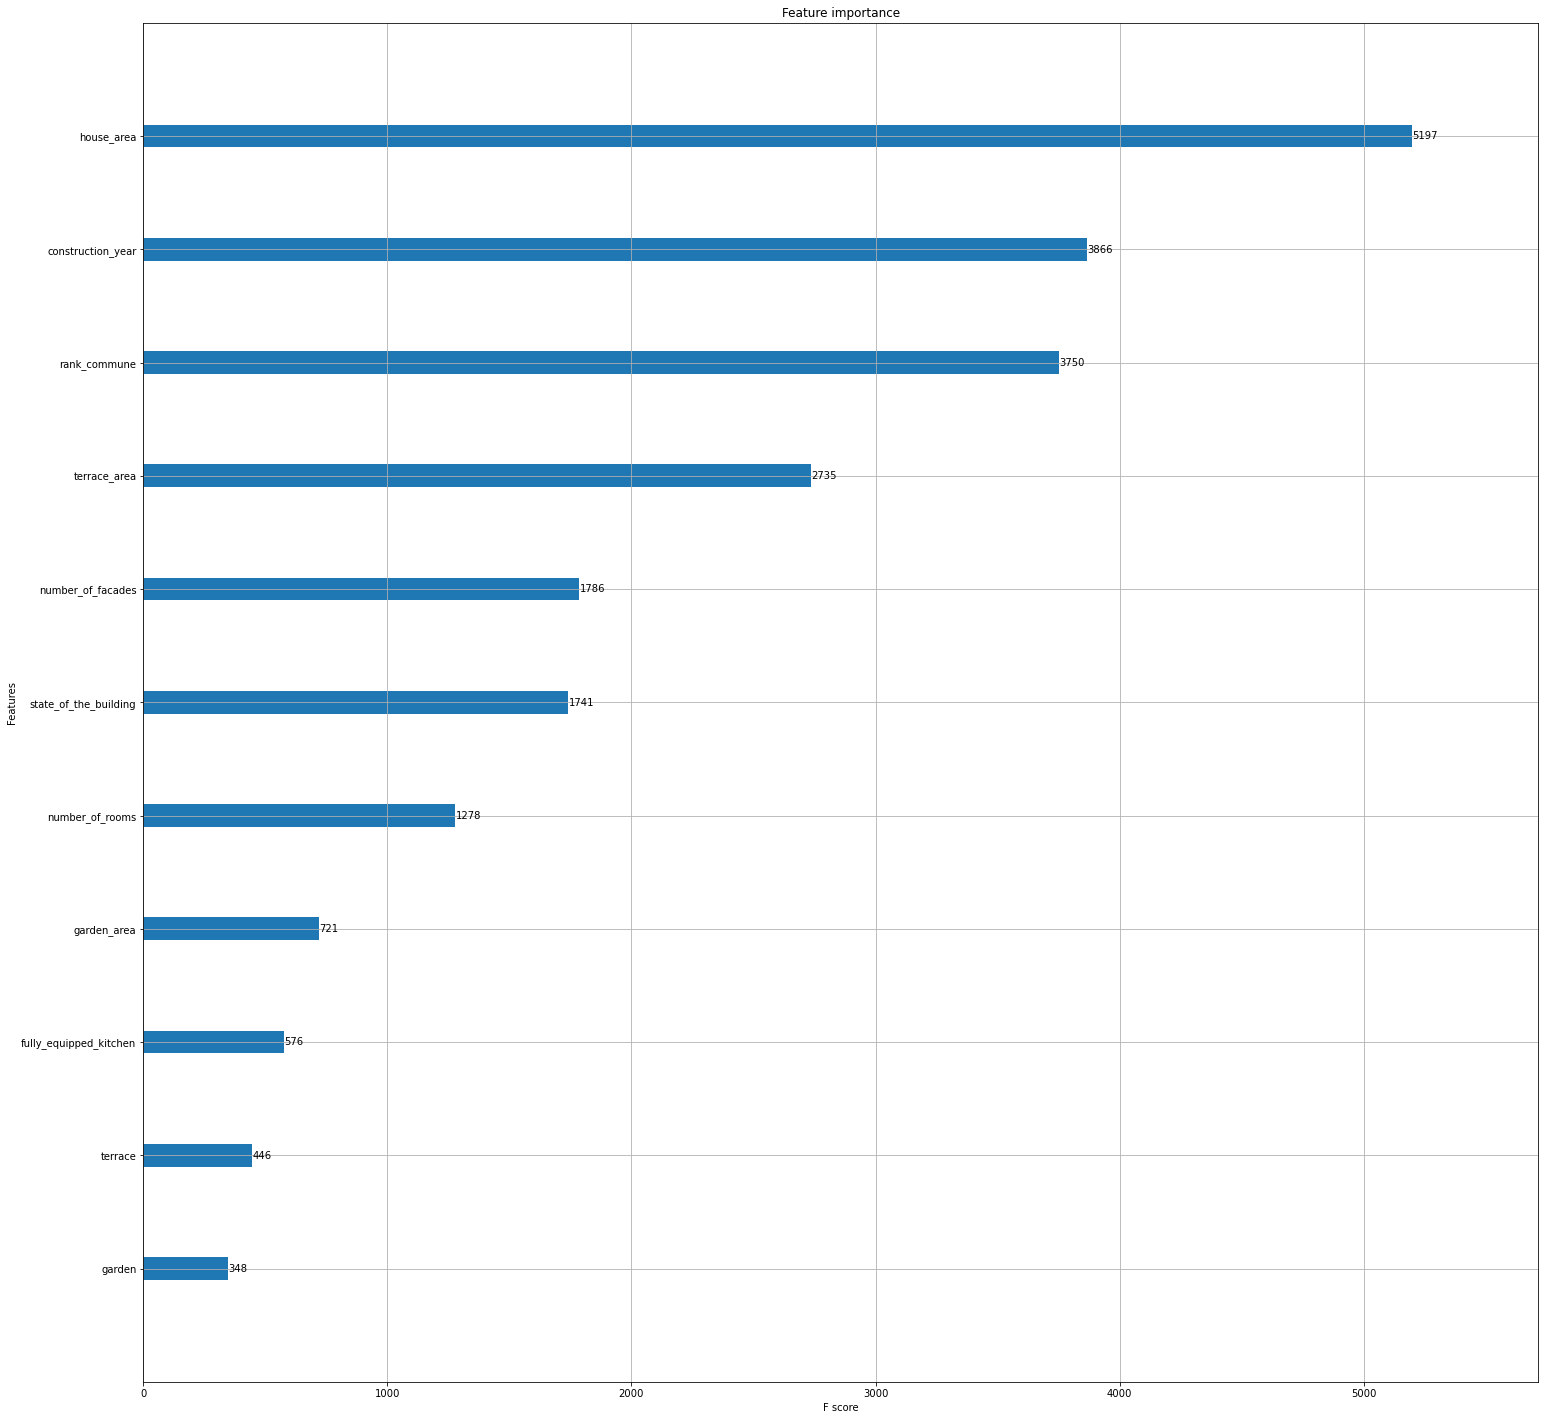

In [51]:
xgb.plot_importance(xgb_reg)
plt.rcParams['figure.figsize'] = [25, 25]
plt.show()

In [52]:
import pickle

model_name = "Apartment_model.pkl"

# save the model
pickle.dump(xgb_reg, open(model_name, "wb"))

# test 
loaded_model = pickle.load(open(model_name, "rb"))
print('model saved') if xgb_reg.score(X_test, y_test) == loaded_model.score(X_test, y_test) else print('error')

model saved
